### Configs

In [1]:
colab = 1

lr_OD = 0.005
lr_DD = 0.01

convert2png = 0


# class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
#                'bus', 'train', 'truck', 'boat', 'traffic light',
#                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
#                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
#                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
#                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
#                'kite', 'baseball bat', 'baseball glove', 'skateboard',
#                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
#                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
#                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
#                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
#                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
#                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
#                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
#                'teddy bear', 'hair drier', 'toothbrush']

               
num_classes = 894

num_epochs = 1

load_model = 1
save_model = 1

path2dataset = "nyu_depth_v2_labeled.mat"

if colab==0:
    root_folder = "Datas"
    OD_model_save_dir = "Models/ODModel.pth.tar"
    DD_model_save_dir = "Models/DDModel.pth.tar"

    OD_logs_path = "Logs/ODLogs.txt"
    DD_logs_path = "Logs/DDLogs.txt"
    
else:
    root_folder = "/content/drive/My Drive/Courses/DeepLearning/Project/Datas"
    
    OD_model_save_dir = "/content/drive/My Drive/Courses/DeepLearning/Project/Models/ODModel.pth.tar"    
    DD_model_save_dir = "/content/drive/My Drive/Courses/DeepLearning/Project/Models/DDModel.pth.tar"

    OD_logs_path = "/content/drive/My Drive/Courses/DeepLearning/Project/Logs/ODLogs.txt"
    DD_logs_path = "/content/drive/My Drive/Courses/DeepLearning/Project/Logs/DDLogs.txt"

### Imports

In [2]:
if colab:
    !pip install mat73
    !pip install timm
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append("/content/drive/My Drive/Courses/DeepLearning/Project")

## Python Files

import utils
import datas
import models
from engine import train_one_epoch_OD, train_one_epoch_DD, evaluate
import transforms as T

## Libraries
import os  # when loading file paths
import numpy as np
from PIL import Image  # Load img
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import mat73
import cv2 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Setting up GPU Device

In [3]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


### Convert .mat to .png images for memory managment during training

In [32]:
if convert2png:
    utils.mat2png(path2dataset)

### Load datas

In [4]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


transform = get_transform(train=True)

train_loader, test_loader = datas.get_loader(root_folder, batch_size=4, num_datas=1449, train_test_ratio=0.9, transform=transform)

### Training  - Object Detector

In [35]:
object_detector = models.ObjectDetector(num_classes=num_classes).to(device)
criterion = nn.MSELoss().to(device)
params = [p for p in object_detector.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr_OD,
                            momentum=0.9, weight_decay=0.0005)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [7]:
if load_model:
      utils.load_checkpoint(torch.load(OD_model_save_dir, map_location=torch.device(device)), object_detector, optimizer)

for epoch in range(num_epochs):
    logs = train_one_epoch_OD(object_detector, optimizer, train_loader, device, epoch, print_freq=5, logs_path=OD_logs_path)
    evaluate(object_detector, test_loader, device=device)
    if save_model:
        checkpoint = {
            "state_dict": object_detector.state_dict(),
            "optimizer": optimizer.state_dict(),
            }
        utils.save_checkpoint(checkpoint, filename=OD_model_save_dir)

=> Loading checkpoint
Epoch: [0]  [  0/326]  eta: 0:27:35  lr: 0.000003  loss: 2.6359 (2.6359)  loss_classifier: 1.3331 (1.3331)  loss_box_reg: 0.6276 (0.6276)  loss_mask: 0.5066 (0.5066)  loss_objectness: 0.0595 (0.0595)  loss_rpn_box_reg: 0.1091 (0.1091)  time: 5.0788  data: 0.3332  max mem: 6027
Epoch: [0]  [  5/326]  eta: 0:26:57  lr: 0.000012  loss: 2.6359 (2.6274)  loss_classifier: 1.3331 (1.3736)  loss_box_reg: 0.5967 (0.6060)  loss_mask: 0.4923 (0.4965)  loss_objectness: 0.0320 (0.0376)  loss_rpn_box_reg: 0.0958 (0.1136)  time: 5.0395  data: 0.4120  max mem: 6315
Epoch: [0]  [ 10/326]  eta: 0:26:24  lr: 0.000022  loss: 2.6790 (2.6642)  loss_classifier: 1.4022 (1.3805)  loss_box_reg: 0.6116 (0.6137)  loss_mask: 0.4923 (0.5014)  loss_objectness: 0.0410 (0.0422)  loss_rpn_box_reg: 0.1214 (0.1265)  time: 5.0156  data: 0.3708  max mem: 6316
Epoch: [0]  [ 15/326]  eta: 0:26:04  lr: 0.000032  loss: 2.6790 (2.7089)  loss_classifier: 1.4201 (1.4147)  loss_box_reg: 0.6276 (0.6309)  loss_

### Training - Depth Estimation

In [39]:
model_type = "DPT_Hybrid"
depth_estimator = models.DepthEstimation(model_type)

depth_estimator.to(device)
criterion = nn.MSELoss().to(device)
params = [p for p in depth_estimator.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr_DD,
                            momentum=0.9, weight_decay=0.0005)

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_hybrid-midas-501f0c75.pt" to /root/.cache/torch/hub/checkpoints/dpt_hybrid-midas-501f0c75.pt


  0%|          | 0.00/470M [00:00<?, ?B/s]

In [41]:
if load_model:
      utils.load_checkpoint(torch.load(DD_model_save_dir, map_location=torch.device(device)), depth_estimator, optimizer)

for epoch in range(num_epochs):
  train_one_epoch_DD(depth_estimator, optimizer, criterion, train_loader, device, epoch, print_freq=20, logs_path=DD_logs_path)

  if save_model:
        checkpoint = {
            "state_dict": depth_estimator.state_dict(),
            "optimizer": optimizer.state_dict(),
            }
        utils.save_checkpoint(checkpoint, filename=DD_model_save_dir)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Epoch = 0 | Itter =  0/326 | Loss = 0.06680511683225632
Epoch = 0 | Itter =  20/326 | Loss = 0.06311796605587006
Epoch = 0 | Itter =  40/326 | Loss = 0.010073216632008553
Epoch = 0 | Itter =  60/326 | Loss = 0.03591860085725784
Epoch = 0 | Itter =  80/326 | Loss = 0.03492118418216705
Epoch = 0 | Itter =  100/326 | Loss = 0.01448589563369751
Epoch = 0 | Itter =  120/326 | Loss = 0.01886608637869358
Epoch = 0 | Itter =  140/326 | Loss = 0.018649838864803314
Epoch = 0 | Itter =  160/326 | Loss = 0.019586864858865738
Epoch = 0 | Itter =  180/326 | Loss = 0.007505838293582201
Epoch = 0 | Itter =  200/326 | Loss = 0.01840945892035961
Epoch = 0 | Itter =  220/326 | Loss = 0.02229018323123455
Epoch = 0 | Itter =  240/326 | Loss = 0.012944921851158142
Epoch = 0 | Itter =  260/326 | Loss = 0.03313218429684639
Epoch = 0 | Itter =  280/326 | Loss = 0.023539738729596138
Epoch = 0 | Itter =  300/326 | Loss = 0.01329750381410122
Epoch = 0 | Itter =  320/326 | Loss = 0.031600672751665115
=> Saving che

### Joint Depth Estimation and Object Detection

In [5]:
if load_model:
      object_detector = models.ObjectDetector(num_classes=num_classes).to(device)
      criterion = nn.MSELoss().to(device)
      params = [p for p in object_detector.parameters() if p.requires_grad]
      optimizer = torch.optim.SGD(params, lr=lr_OD,
                                  momentum=0.9, weight_decay=0.0005)
      utils.load_checkpoint(torch.load(OD_model_save_dir, map_location=torch.device(device)), object_detector, optimizer)
      model_type = "DPT_Hybrid"
      depth_estimator = models.DepthEstimation(model_type)
      depth_estimator.to(device)

=> Loading checkpoint


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


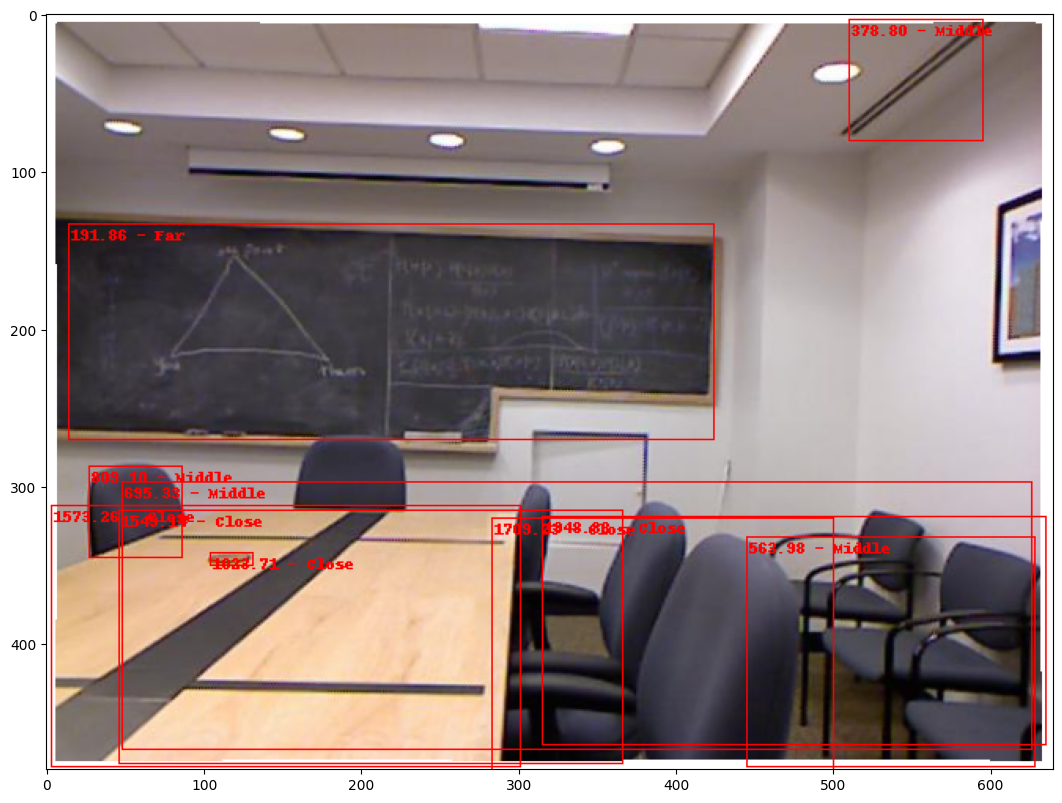

In [6]:
concater = models.Concater(object_detector, depth_estimator)
images, depths, targets = next(iter(train_loader))
images = list(image for image in images)
img = images[3].to(device)

plot_img = concater.out(img)

fig = plt.figure()
fig.set_size_inches(18, 10)
fig.set_dpi(100)
plt.imshow(plot_img)
plt.show()